## Load and Clean Data

1. Both TE and gene data generated by UROMOL group is loaded into a pandas dataframe
2. Samples are ordered by there UROMOL ID ('U0001' -> 'U2122')
3. All simple repeat elements are eliminated
4. Elements with no expression in any sample were also removed

In [3]:
import pandas as pd
from Funcs.ReorderUROMOL import UROMOLreorder
import json

# load in both Gene and TE transcriptomic expression
Gene = pd.read_csv('~/Desktop/UROMOL-TE/UROMOL-GENE-VST.csv', index_col='Unnamed: 0')
TE = pd.read_csv('~/Desktop/UROMOL-TE/UROMOL-TE-VST.csv', index_col='Unnamed: 0')
RepName = pd.read_csv('~/Desktop/UROMOL-TE/TE-RepName.csv', index_col= 'Unnamed: 0', usecols=[0, 3])
IntronTE = pd.read_csv('~/Desktop/UROMOL-TE/UROMOL-INTRONTE-RAW.csv', index_col='Unnamed: 0')
IntergenicTE = pd.read_csv('~/Desktop/UROMOL-TE/UROMOL-INTERGENICTE-RAW.csv', index_col='Unnamed: 0')
ExonTE = pd.read_csv('~/Desktop/UROMOL-TE/UROMOL-EXONICTE-RAW.csv', index_col='Unnamed: 0')

# load in TCGA data for comparison
GeneTCGA = pd.read_csv('~/Desktop/TCGA-TE/TCGA-GENE.csv', index_col='Unnamed: 0')
TETCGA = pd.read_csv('~/Desktop/TCGA-TE/TCGA-TE.csv', index_col='Unnamed: 0')
IntronTETCGA = pd.read_csv('~/Desktop/TCGA-TE/TCGA-INTRONTE-RAW.csv', index_col='Unnamed: 0')
IntergenicTETCGA = pd.read_csv('~/Desktop/TCGA-TE/TCGA-INTERGENICTE-RAW.csv', index_col='Unnamed: 0')
ExonTETCGA = pd.read_csv('~/Desktop/TCGA-TE/TCGA-EXONICTE-RAW.csv', index_col='Unnamed: 0')

# order the dataframe by UROMOL ID
IDs = []
for sample in TE.columns.tolist():
    IDs.append(int(sample.split('U')[1]))

TE = UROMOLreorder(IDs, TE)
IntronTE = UROMOLreorder(IDs, IntronTE)
IntergenicTE = UROMOLreorder(IDs, IntergenicTE)
ExonTE = UROMOLreorder(IDs, ExonTE)
Gene = UROMOLreorder(IDs, Gene)

# eliminate all simple repeat and unwanted elements from the TE dataset
TransposableClasses = ['LINE', 'SINE', 'LTR', 'DNA', 'Retroposon']
TENames = RepName[RepName['repClass'].isin(TransposableClasses)].index.values.tolist()
TE = TE.loc[TENames, :]
TETCGA = TETCGA.loc[TENames, :]

# There are two TEs that are not captured in the intronic or intergenic data
TENames.remove('HERV-Fc2-int')
TENames.remove('MLT1M-int')
IntronTE = IntronTE.loc[TENames, :]
IntergenicTE = IntergenicTE.loc[TENames, :]
IntronTETCGA = IntronTETCGA.loc[TENames, :]
IntergenicTETCGA = IntergenicTETCGA.loc[TENames, :]

# Many of the TEs are not found in the Exonic data, the full list can be found at NotExonTE.json
with open("NotExonTE.json") as f:
    NotinExon = json.load(f)
TEexonNames = [x for x in TENames if x not in NotinExon]
ExonTE = ExonTE.loc[TEexonNames, :]
ExonTETCGA = ExonTETCGA.loc[TEexonNames, :]

# remove all TE and Gene elements with no expression
TE = TE.loc[~(TE==0).all(axis=1)]
Gene = Gene.loc[~(Gene==0).all(axis=1)]
IntronTE = IntronTE.loc[~(IntronTE==0).all(axis=1)]
IntergenicTE = IntergenicTE.loc[~(IntergenicTE==0).all(axis=1)]
ExonTE = ExonTE.loc[~(ExonTE==0).all(axis=1)]

TETCGA = TETCGA.loc[~(TETCGA==0).all(axis=1)]
GeneTCGA = GeneTCGA.loc[~(GeneTCGA==0).all(axis=1)]
IntronTETCGA = IntronTETCGA.loc[~(IntronTETCGA==0).all(axis=1)]
IntergenicTETCGA = IntergenicTETCGA.loc[~(IntergenicTETCGA==0).all(axis=1)]
ExonTETCGA = ExonTETCGA.loc[~(ExonTETCGA==0).all(axis=1)]

## Percentage of TEs in RNA-seq Data

Although a substantial fraction of the genetic material, transposable elements are transcribed in low numbers. As such, we should ensure that RNA-seq samples contain only a small fraction of TE mapped reads

1. Sum TE and Gene expression
2. Calculate the percentage of transcripts mapping to TEs
3. Generate a stackplot, with a mean line

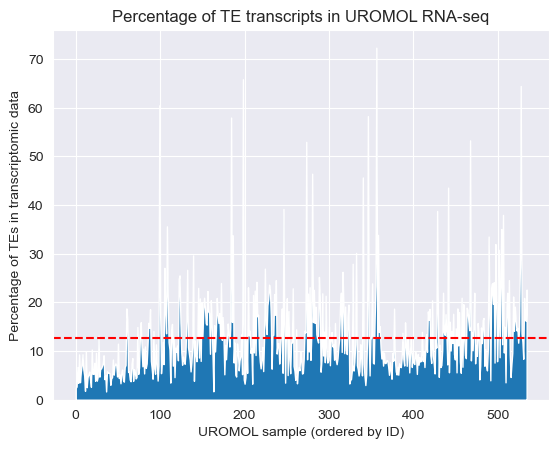

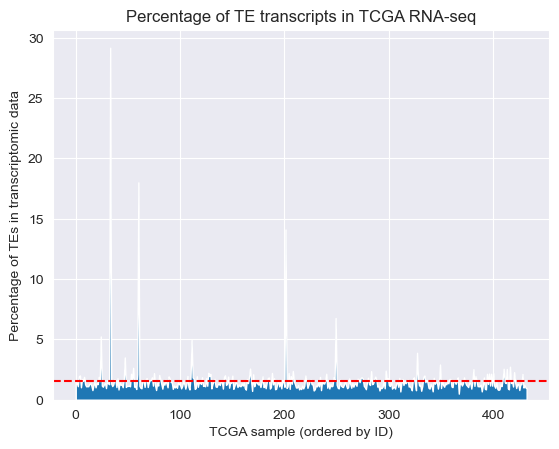

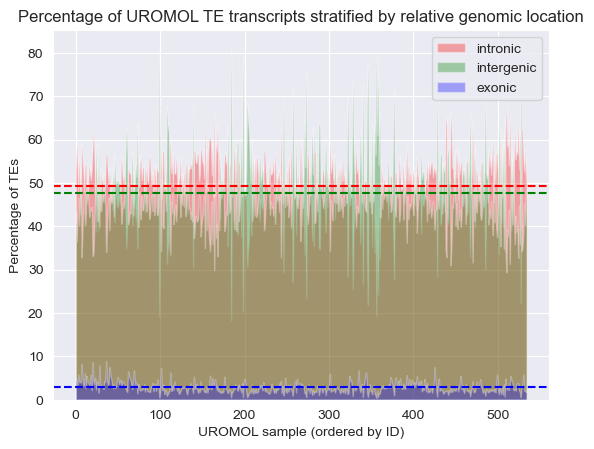

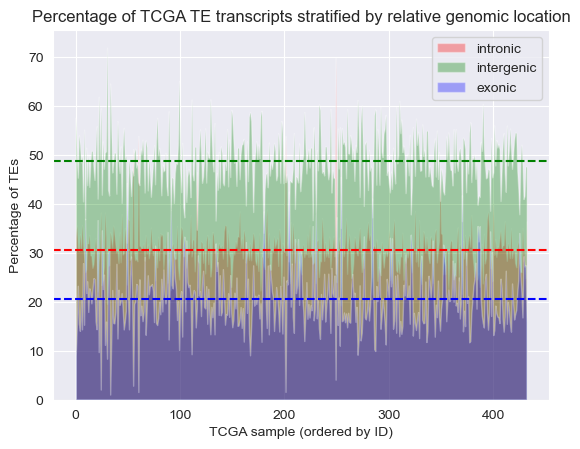

In [13]:
from Funcs.TEtranscriptomicPercent import plotTEpercent
from Funcs.TEGenomicLocationPercent import TEGenomicLocationPercent

plotTEpercent(TE, Gene, 'UROMOL')
plotTEpercent(TETCGA, GeneTCGA, 'TCGA')
TEGenomicLocationPercent(TE, IntronTE, IntergenicTE, ExonTE, 'UROMOL')
TEGenomicLocationPercent(TETCGA, IntronTETCGA, IntergenicTETCGA, ExonTETCGA, 'TCGA')

# Outlier Detection

## Data Distribution - Histogram

<AxesSubplot:ylabel='Frequency'>

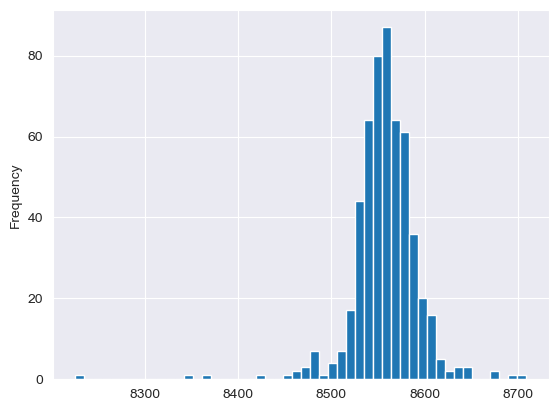

In [2]:
TE.sum(axis='rows').plot.hist(bins=50)

## Batch Effect Evaluation

1. Both clean TE and Gene datasets were zero centered and log2 transformed
2. Boxplot are generated for both normalized dataframes

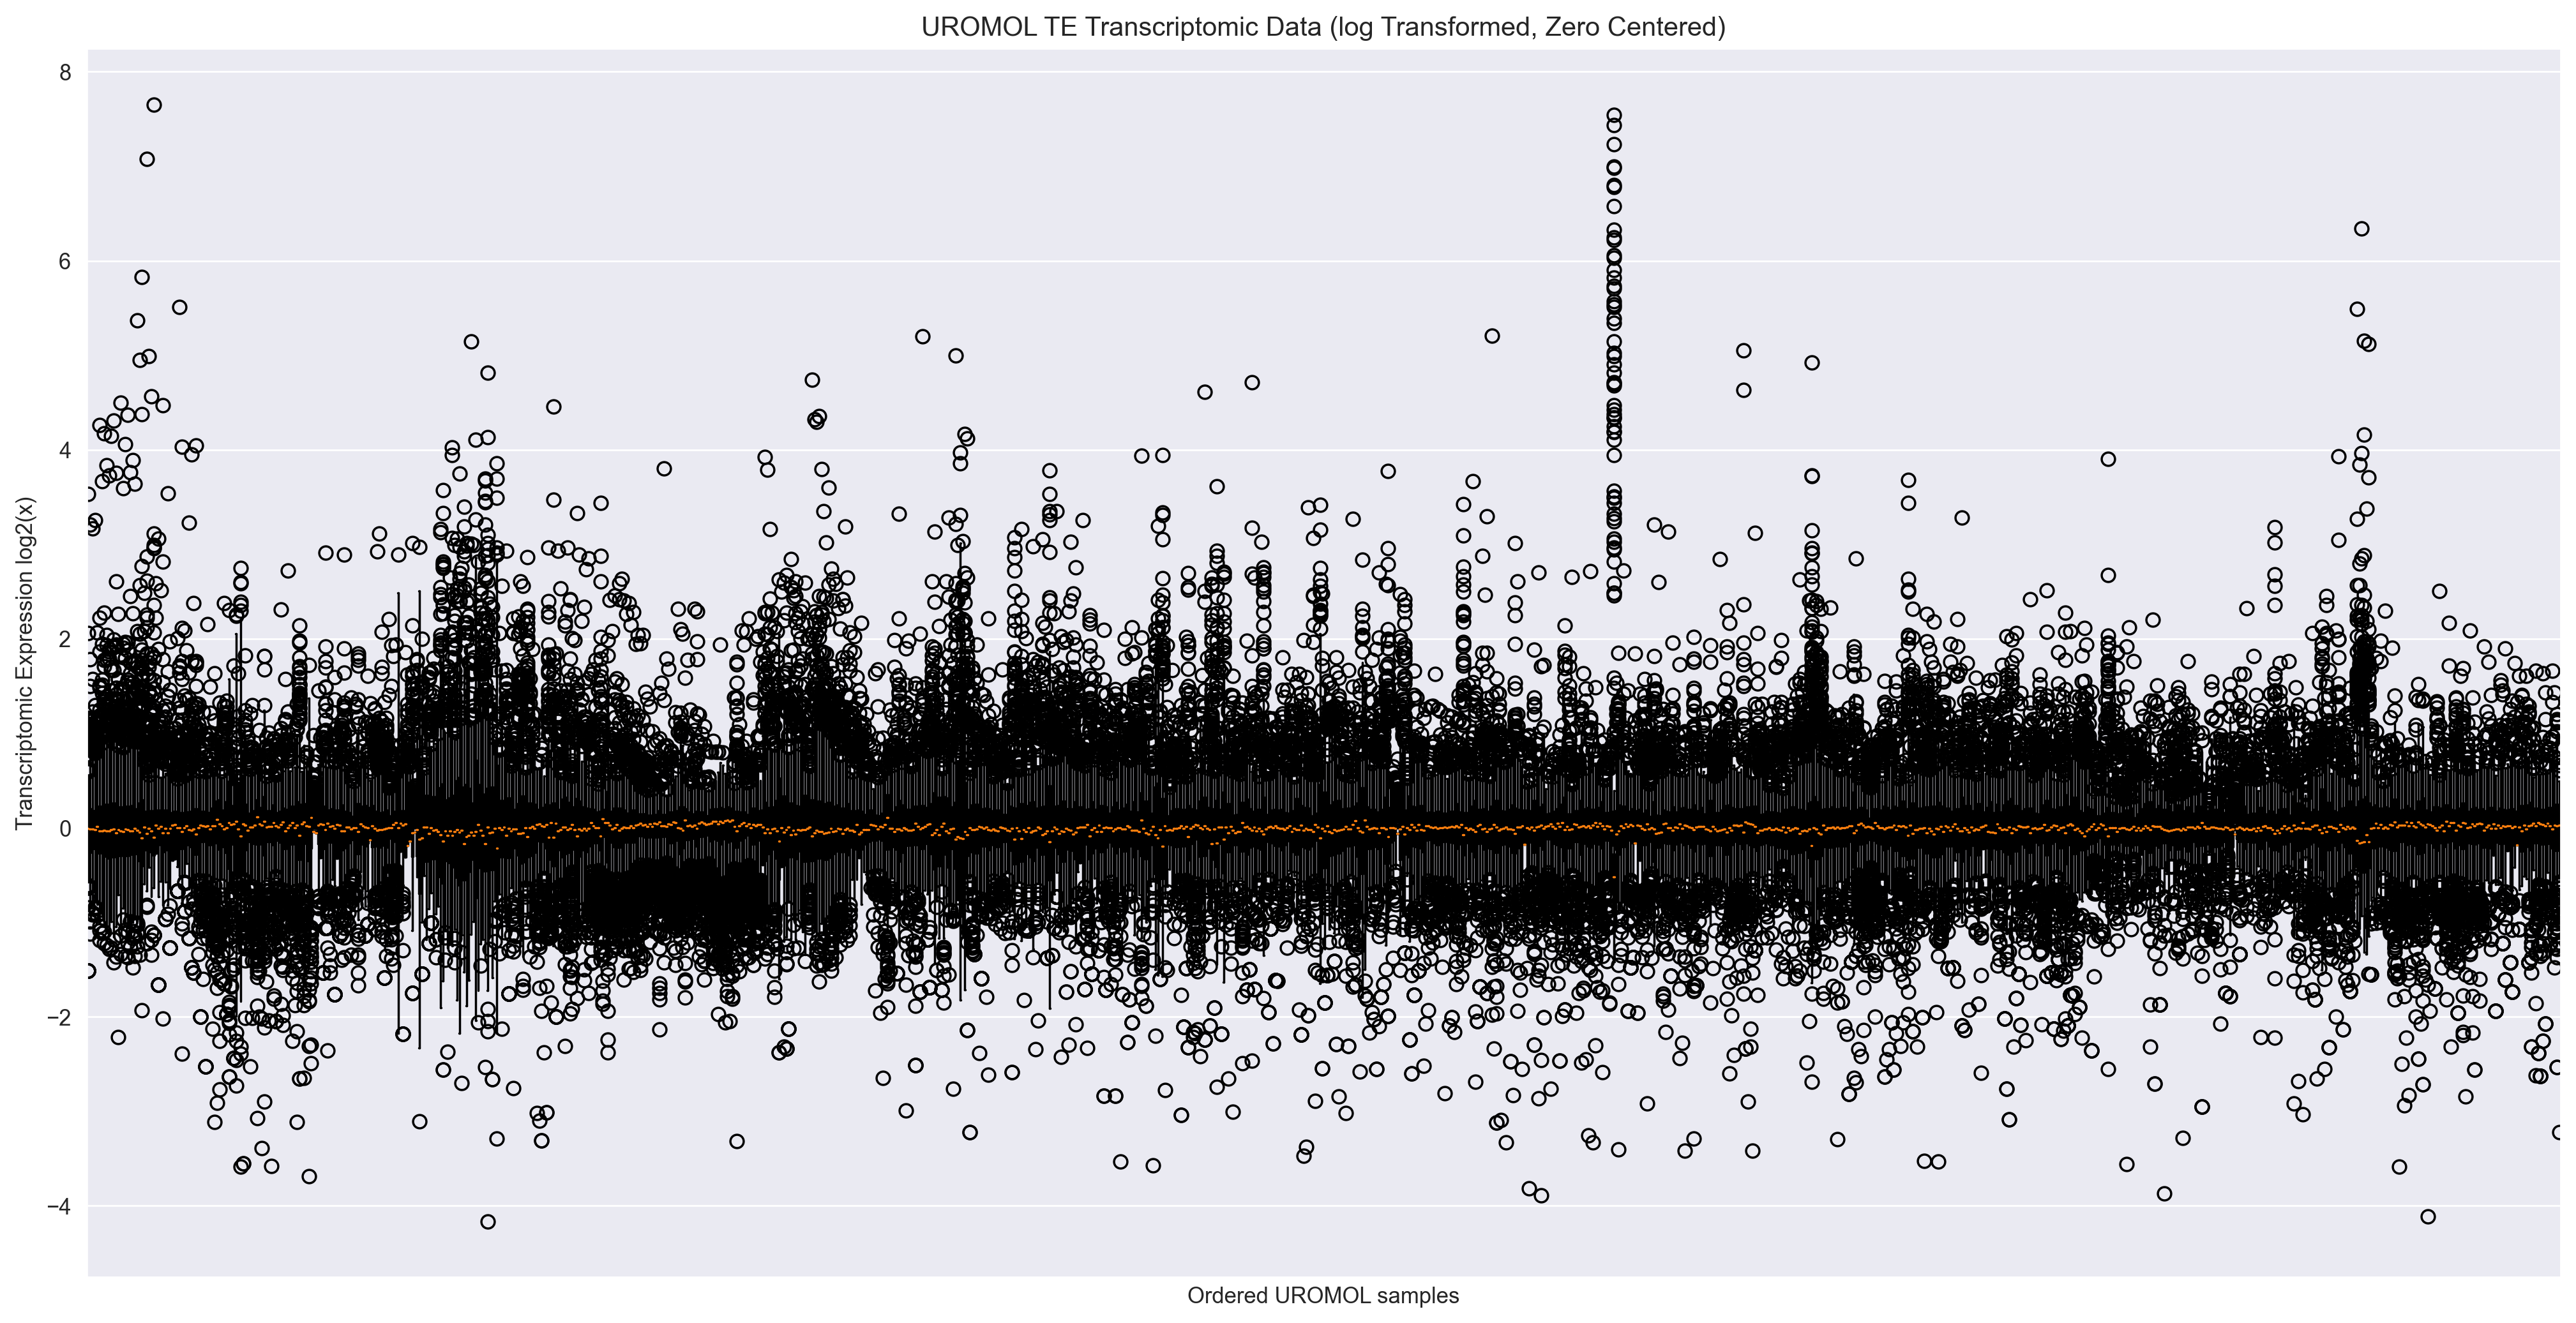

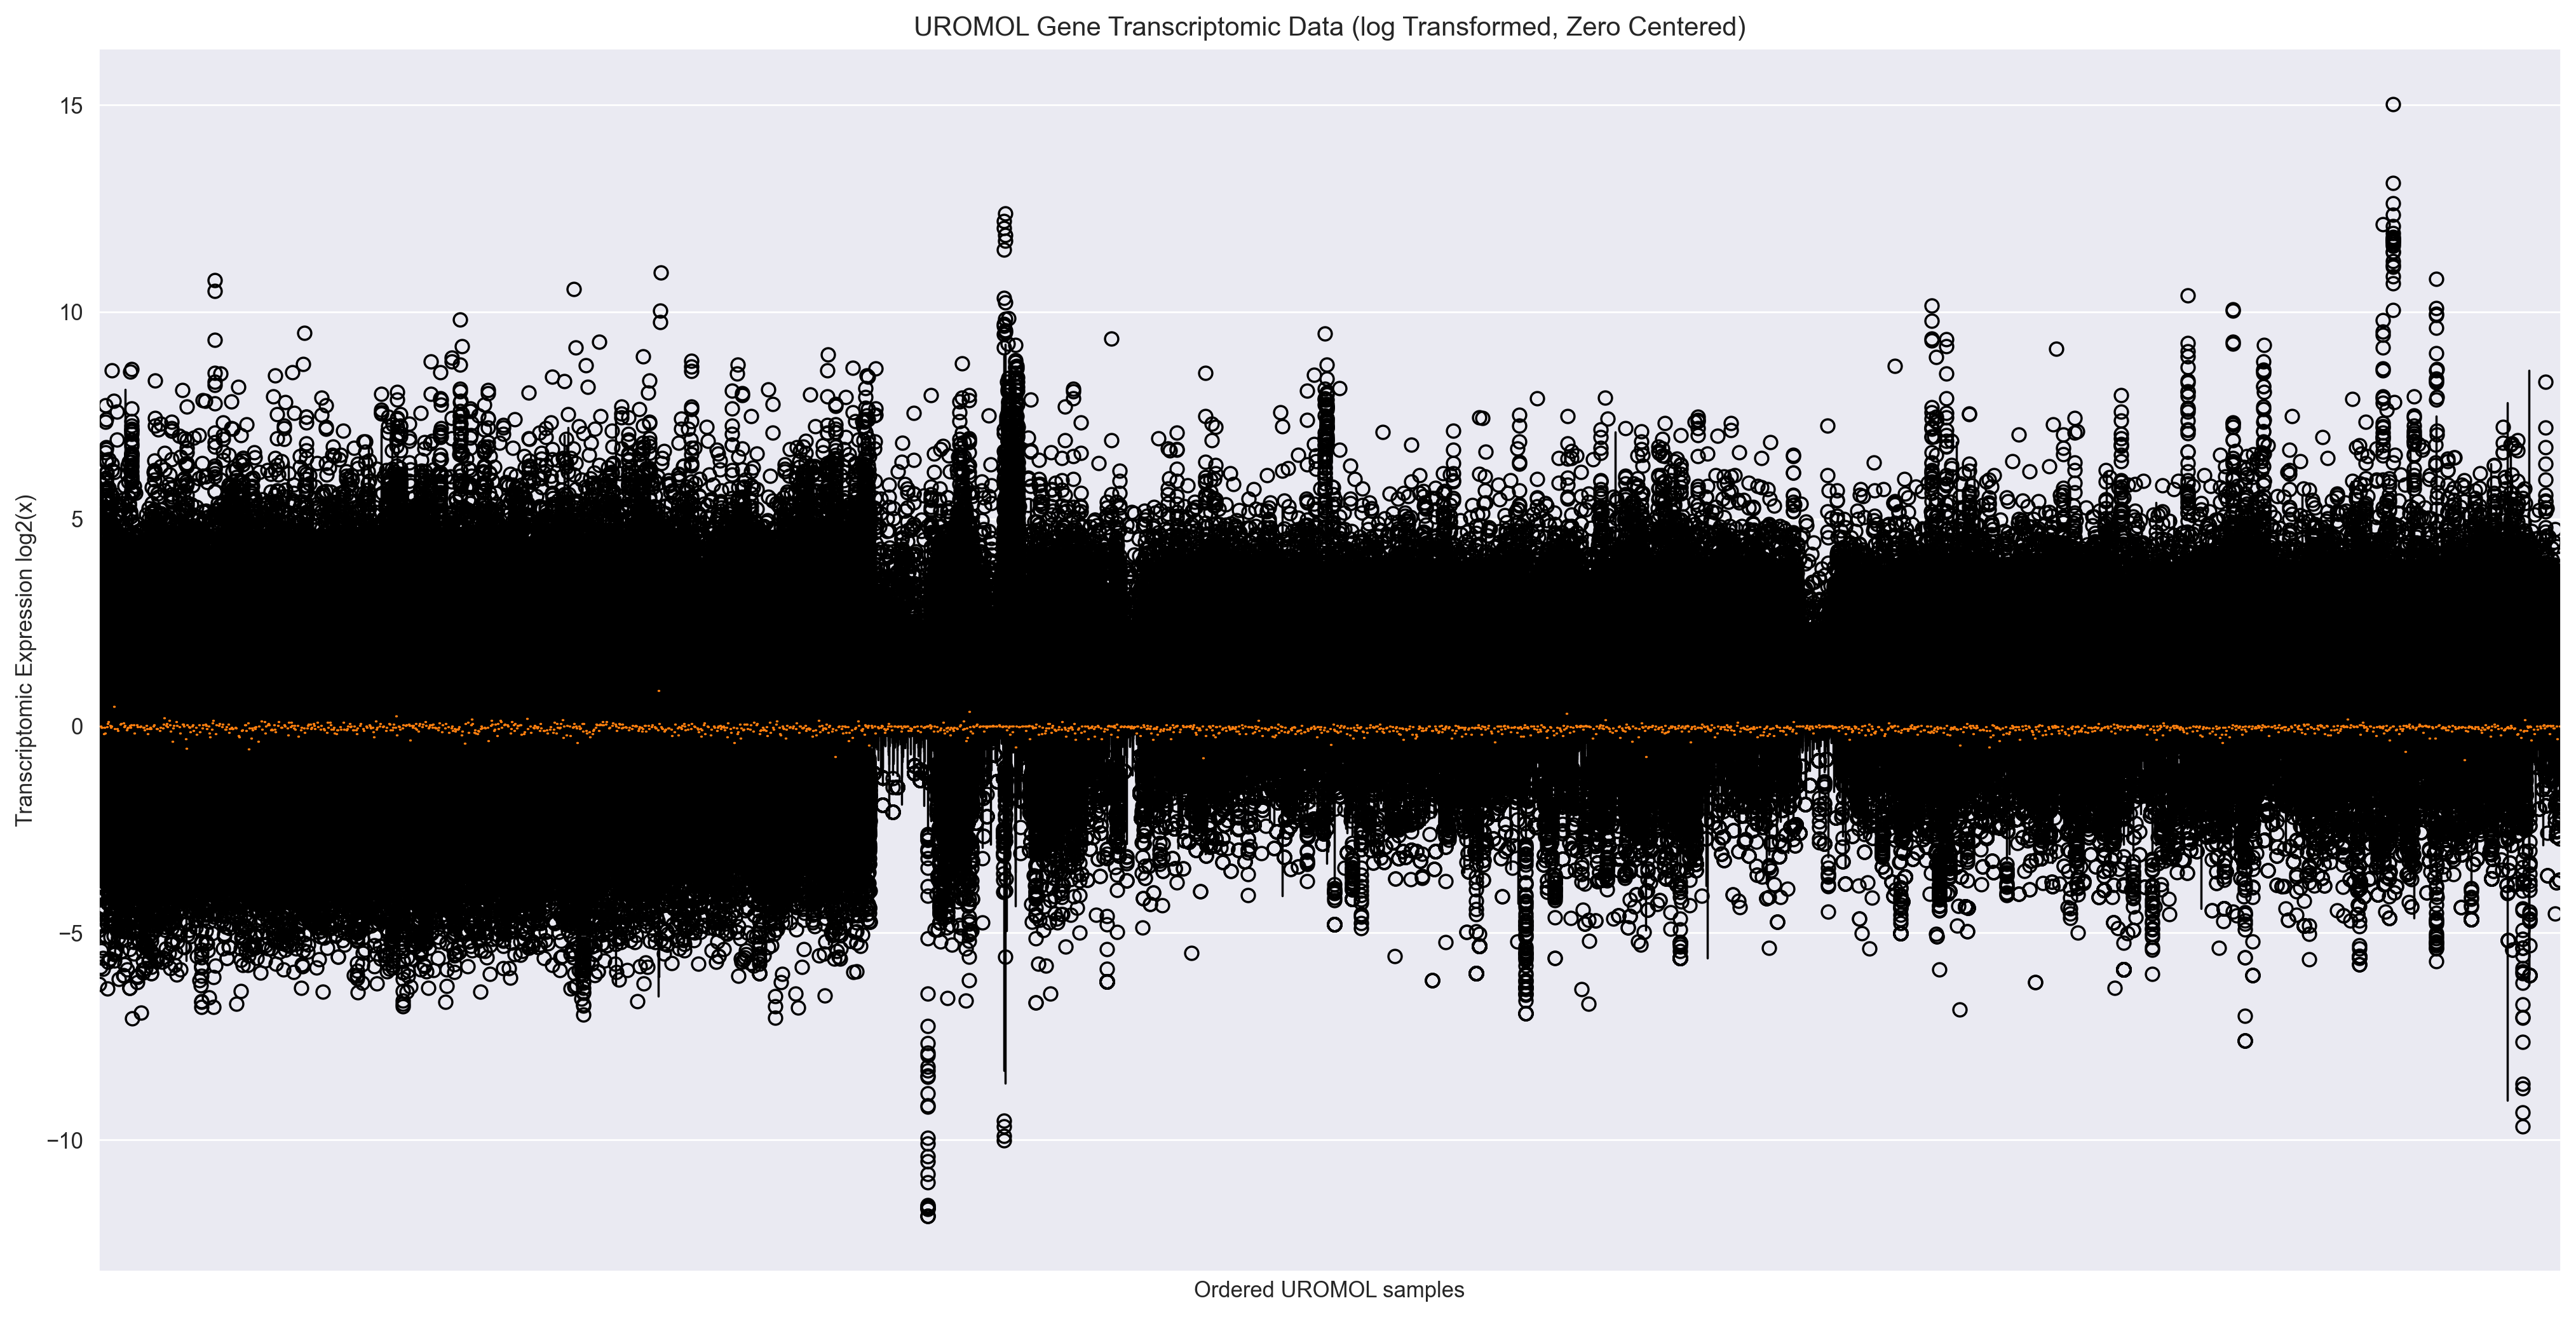

In [2]:
from Funcs.Boxplot import GenerateBoxplot

GenerateBoxplot(TE, 'TE', 'UROMOL-TEBoxplot.png')
GenerateBoxplot(Gene, 'Gene', 'UROMOL-GeneBoxplot.png')

## Interquartile Range Outlier Detection

1. Evaluated the IQR of each sample
2. outiers outlined based on n>300 (k = 1.5) and returned in function
    - David C. Hoaglin & Boris Iglewicz (1987) Fine-Tuning Some Resistant Rules for Outlier Labeling, Journal of the American Statistical Association, 82:400, 1147-1149, DOI: 10.1080/01621459.1987.10478551

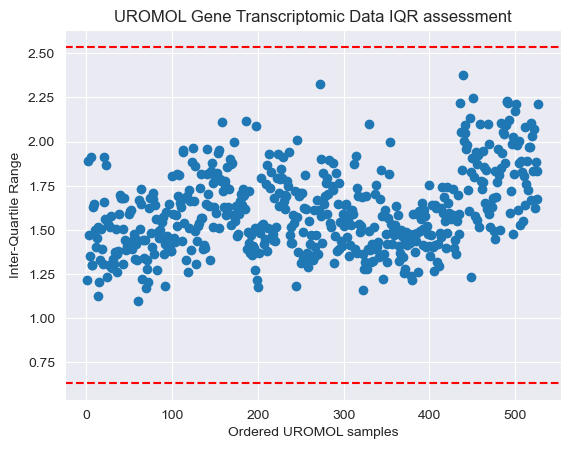

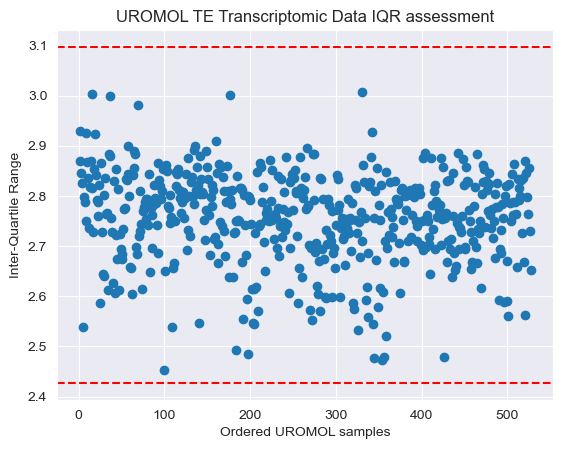

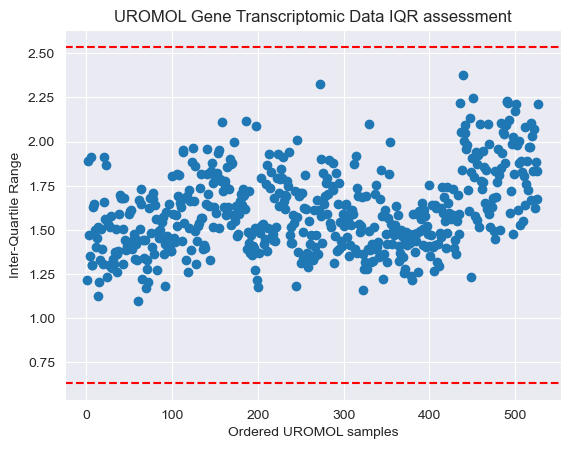

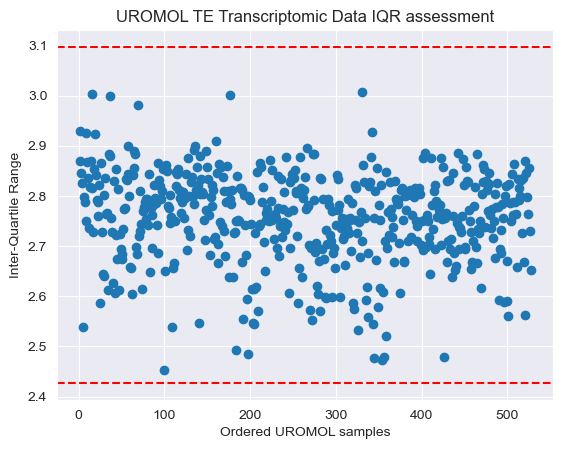

In [14]:
from Funcs.PlotIQR import plotiqr

IQRGeneoutliers = plotiqr(Gene, 'Gene')
IQRTEoutliers = plotiqr(TE, 'TE')

outliers = list(set(IQRTEoutliers + IQRGeneoutliers))

TE = TE.drop(outliers, axis='columns')
Gene = Gene.drop(outliers, axis='columns')

IQRGeneoutliers = plotiqr(Gene, 'Gene')
IQRTEoutliers = plotiqr(TE, 'TE')

TE.to_csv('Clean-UROMOL-TE.csv')
Gene.to_csv('Clean-UROMOL-GENE.csv')

## Spearman Correlation

how similar are data samples to each other?


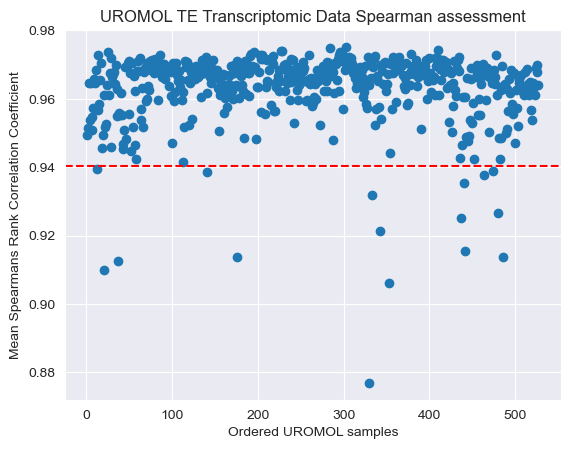

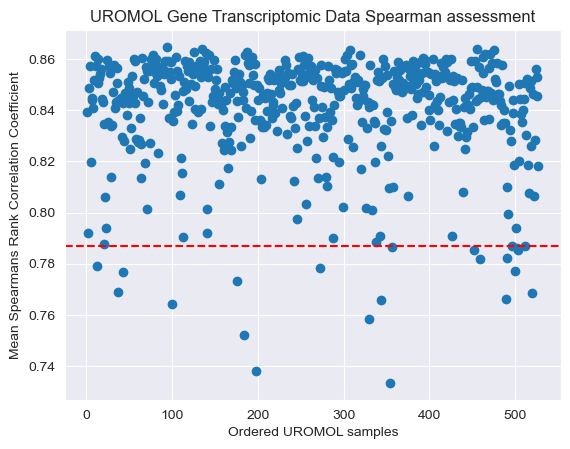

In [5]:
import seaborn as sns
from Funcs.PlotSpearman import plotSpearman
import matplotlib.pyplot as plt

TEspearman = TE.corr(method='spearman')
TEspearmanmean = TEspearman.mean(axis='rows')
plotSpearman(TEspearmanmean, 'TE')

Genespearman = Gene.corr(method='spearman')
Genespearmanmean = Genespearman.mean(axis='rows')
plotSpearman(Genespearmanmean, 'Gene')

#sns.heatmap(TEspearman, annot = True)
#plt.savefig('~/Desktop/UROMOL-TE/Plots/TESpearmanCorr.png')
#
#sns.heatmap(Genespearman, annot = True)
#plt.savefig('~/Desktop/UROMOL-TE/Plots/GeneSpearmanCorr.png')

## DBSCAN Outlier Detection

1. Compute and plot the explained variance ratio of the top 100 principal components
2. Evaluate PCs that explain <95% of the data variance (in my case <95% is explained by PC1, so I will evaluate 2 PCs)
3. Compute optimal epsilon value for DBSCAN (compute nearest neighbours distances and set epsilon as point of inflection

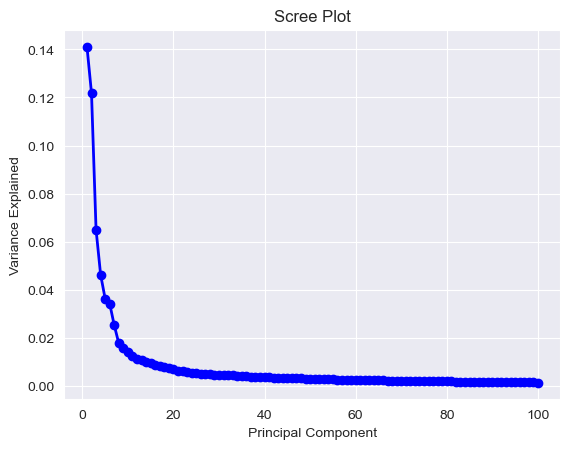

In [6]:
from Funcs.PCAExplainedVarienceRatio import PlotScree

ExplainedVarienceRatio = PlotScree(TE)

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import numpy as np

tTE = TE.transpose()

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(tTE)
principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['principal component 1',
                                      'principal component 2'],
                           index=tTE.index.values.tolist())
print(principalDf.head())

       principal component 1  principal component 2
U0001             -11.060077               4.601900
U0002               1.096165               2.070815
U0006              -0.570501              -0.442250
U0007             -10.387177               3.883853
U0010               2.478836               4.473521


[0.0301792  0.0301792  0.03756956 0.03756956 0.03879912 0.03879912
 0.04550097 0.04550097 0.04640358 0.04640358 0.04693886 0.04693886
 0.05166431 0.05166431 0.05186975 0.05442901 0.05442901 0.05542733
 0.05542733 0.05748441 0.05748441 0.06425176 0.06425176 0.06753432
 0.06753432 0.0679576  0.0679576  0.07173899 0.07173899 0.07470186
 0.07470186 0.08138222 0.08291931 0.08531585 0.08531585 0.08571591
 0.08571591 0.08899269 0.08899269 0.08942629 0.09009929 0.09009929
 0.09145163 0.09145163 0.09165447 0.09230062 0.09230062 0.09273831
 0.09273831 0.09566058 0.09566058 0.09578356 0.09578356 0.09799322
 0.09799322 0.09998865 0.09998865 0.10327184 0.10327184 0.10332108
 0.10332108 0.10614648 0.1068812  0.1068812  0.10856461 0.10856461
 0.10918403 0.11009251 0.11009251 0.11278199 0.11278199 0.11656917
 0.11656917 0.11708281 0.11708281 0.11845033 0.11845033 0.12022794
 0.12022794 0.12029897 0.12029897 0.12099767 0.12099767 0.12172035
 0.12172035 0.12362986 0.12362986 0.12465887 0.12465887 0.1257

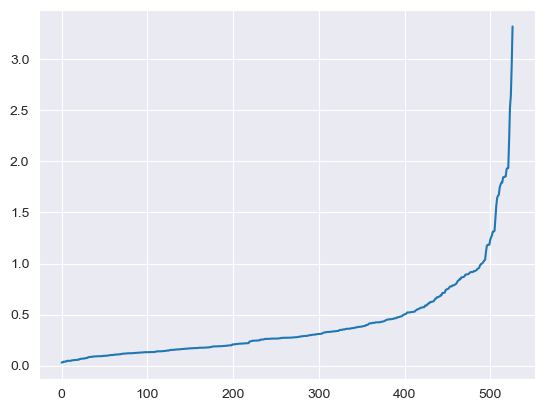

In [8]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(principalDf)
distances, indices = nbrs.kneighbors(principalDf)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
print(distances)
plt.plot(distances)

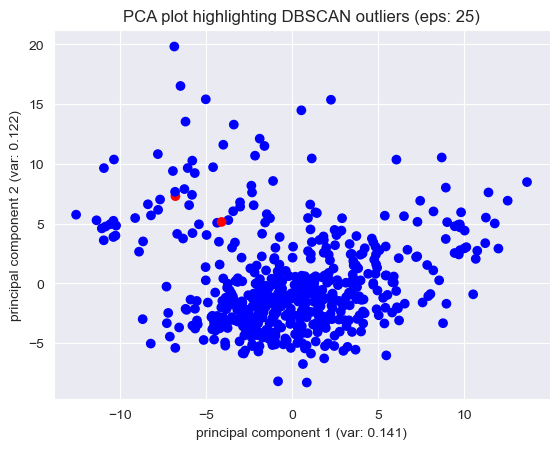

In [13]:
from sklearn.cluster import DBSCAN
epsilon = 25
dbscan = DBSCAN(eps = epsilon, min_samples = 5)
tTEoutlier = dbscan.fit(tTE)
clusters = tTEoutlier.labels_

outlier = []
colors = []

for cluster in clusters:
    if cluster < 0:
        colors.append('r')
        outlier.append(1)
    else:
        colors.append('b')
        outlier.append(0)

tTE.loc[:, 'outlier'] = outlier

plt.scatter(principalDf.loc[:,'principal component 1'],
            principalDf.loc[:, 'principal component 2'],
            c=colors)
plt.title(f'PCA plot highlighting DBSCAN outliers (eps: {round(epsilon, 3)})')
plt.xlabel(f'principal component 1 (var: {round(ExplainedVarienceRatio[0], 3)})')
plt.ylabel(f'principal component 2 (var: {round(ExplainedVarienceRatio[1], 3)})')
plt.savefig('PCA-DBSCAN-Outliers.png')
plt.show()

In [9]:
outlier = tTE.loc[:, 'outlier']
outlier.loc[~(outlier==0)]
#tTE.loc[:, 'outlier'].to_csv('UROMOL-Outliers.csv')

U0183    1
U0434    1
U0516    1
U0965    1
U1232    1
U1242    1
U2026    1
U2027    1
U2032    1
U2038    1
U2045    1
U2051    1
U2053    1
U2056    1
U2058    1
U2060    1
U2065    1
U2077    1
U2091    1
U2115    1
Name: outlier, dtype: int64